In [3]:
import torch
import torch.nn as nn
from torchinfo import summary
# model.summary()：可清晰展示模型架构细节，如各层输入输出维度、参数数量、乘加操作次数

In [7]:
class LeNet(nn.Module):
    def __init__(self,num_classes = 10):
        super(LeNet,self).__init__()
        # 调用父类nn.Module的初始化方法
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 6,kernel_size = 5)
        # 卷积层1: 输入一个通道（如灰色图像），输出六个通道，卷积核大小为5 x 5
        self.conv2 = nn.Conv2d(in_channels = 6,out_channels = 16,kernel_size = 5)
        # 卷积层2：输入6个通道，输出16个通道，卷积核大小为5 x 5
        self.fc1 = nn.Linear(in_features = 16 * 4 * 4,out_features = 120)
        # 全连接层1：输入特征数为16*4*4，输出120个节点
        self.fc2 = nn.Linear(in_features = 120,out_features = 84)
        # 全连接层2：输入特征数为120，输出84个节点
        self.fc3 = nn.Linear(in_features = 84,out_features = num_classes)
    def forward(self,x):
        x = torch.relu(self.conv1(x))
        # 对卷积层1的输出应用ReLU激活函数
        x = nn.functional.max_pool2d(x,kernel_size = 2)
        # 最大池化操作，缩小特征图尺寸
        x = torch.relu(self.conv2(x))
        # 对卷积层2的输出应用ReLU激活函数
        x = nn.functional.max_pool2d(x,kernel_size = 2)
        # 再次池化
        x = x.view(-1,16*4*4)
        # 展开张量， 以便输入全连接层
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
summary(LeNet(),input_size = (1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 24, 24]            156
├─Conv2d: 1-2                            [1, 16, 8, 8]             2,416
├─Linear: 1-3                            [1, 120]                  30,840
├─Linear: 1-4                            [1, 84]                   10,164
├─Linear: 1-5                            [1, 10]                   850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
Total mult-adds (M): 0.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.18
Estimated Total Size (MB): 0.22

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from tqdm import *
import numpy as np
import sys

Epoch: 0 Loss: 2.7257871331118952 Acc: 0.5332
Epoch: 2 Loss: 2.011362456708309 Acc: 0.8817  
Epoch: 4 Loss: 1.764854188374556 Acc: 0.9361  
Epoch: 6 Loss: 1.608087818012538 Acc: 0.956   
Epoch: 8 Loss: 1.4965485479480274 Acc: 0.9638 
100%|██████████| 10/10 [01:05<00:00,  6.60s/it]


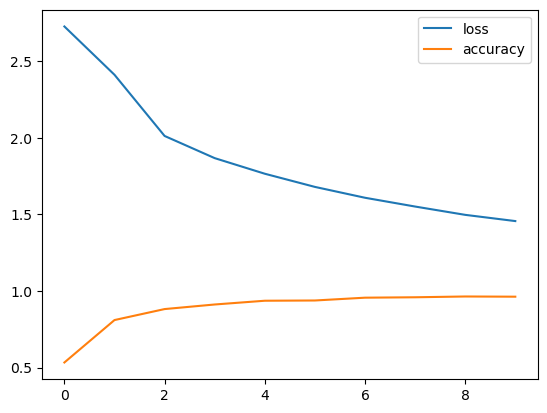

Accuracy: 0.9625


In [21]:
torch.manual_seed(86)

model = LeNet()
optimizer = optim.SGD(model.parameters(),lr = 0.02)
criterion = nn.CrossEntropyLoss()

transform = transforms.Compose([
    transforms.ToTensor()
])
# 创建数据变化，将是图像数据转换为PyTorch张量

train_dataset = datasets.MNIST(root = '/data/mnist/',train = True,download = True,transform = transform)
train_loader = DataLoader(train_dataset,batch_size = 256, shuffle = True)
# 创建训练数据加载器，
test_dataset = datasets.MNIST(root = '/data/mnist/',train = False,download = True,transform = transform) 
test_loader = DataLoader(test_dataset , batch_size = 256, shuffle = False)

num_epochs = 10
loss_history = []
acc_history = []

for epoch in tqdm(range(num_epochs), file = sys.stdout):
# 使用tqdm库创建进度条
    total_loss = 0
    total_correct = 0

    model.train()
    # 将模型设置为训练模式
    for inputs , labels in train_loader:
    # 遍历训练数据加载器train_Loader，每次迭代获取一个批量的输入数据inputs和标签labels
        optimizer.zero_grad()
        # 梯度清零
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # 累加当前批量的损失值（loss.item()获取标量形式的损失值）
    model.eval()
    with torch.no_grad():
        for inputs,labels in test_loader:
            outputs = model(inputs)
            total_correct += (outputs.argmax(1) == labels).sum().item()
            # 计算预测正确的样本数
            # outputs.argmax(1)获取没样本预测类别（概率最大的索引），与真是标签labels比较，求和后用.item()转为标量并累加

    loss_history.append(np.log10(total_loss))
    acc_history.append(total_correct / len(test_dataset))

    if epoch % 2 == 0:
        tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(epoch,loss_history[-1],acc_history[-1]))

import matplotlib.pyplot as plt
plt.plot(loss_history, label = 'loss')
plt.plot(acc_history, label = 'accuracy')
plt.legend()
plt.show()

print("Accuracy:", acc_history[-1])